In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU, Masking, Lambda, Concatenate
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from numpy import argmax
# from pickle import load
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
# # from nltk.translate.bleu_score import corpus_bleu
import json
# import random
import csv

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

#Wesam
# SEED = 10
#IMAGE_EMBEDDING_VAL_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/validation/'
# IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/one_sample_cnn/'
# filepath = '/content/drive/My Drive/Colab_Notebooks/DL_data/model-ep{epoch:03d}-loss{loss:.3f}.h5'
#CAPTION_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/image_to_caption.csv'



#on my Colab
ALL_CAPTIONS_FILE = '/content/drive/My Drive/Colab_Notebooks/DL_data/all_captions.txt'
COMPLETE_STORIES_FILE = '/content/drive/My Drive/Colab_Notebooks/DL_data/complete_stories_all_splits.json'
IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/'
GLOVE_EMBEDDING_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/glove.6B.300d.txt'


# #For my GCP:
# ALL_CAPTIONS_FILE = 'all_captions.txt'
# COMPLETE_STORIES_FILE = 'complete_stories_all_splits.json'
# IMAGE_EMBEDDING_DIR = 'CNNFeatureVectors/'
# GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'


#Vinuta
SEED = 10
IMAGE_EMBEDDING_DIM = 2048
#IMAGE_EMBEDDING_DIR = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/'
NUM_IMAGE_EMBEDDING_CHUNKS = 10
#GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'
MAX_SEQUENCE_LENGTH = 20
WORD_EMBEDDING_DIM = 300
#CAPTION_FILE_NAME = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/image_to_caption.csv'
SENTENCE_EMBEDDING_DIM = 512

Using TensorFlow backend.


In [2]:
#commented for GCP
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#PreProcess Captions / Stories

Either call this function or simply load preprocessed from a file



In [0]:
#to check if story ids are repeated or unique
# story_list = list()
# for key in list(all_captions_dict.keys()):
#   story_list += list(all_captions_dict[key].keys())
# from collections import Counter
# print(len(story_dict))
# d =  Counter(story_dict)
# res = [k for k, v in d.items() if v > 1]
# print(len(res)) ## gave zero .. so story ids are -in fact- unique


#image_embd =  getImageEmbedding(IMAGE_EMBEDDING_DIR)

def get_existing_stories(image_embeddings):
  #load all_captions file
  with open(ALL_CAPTIONS_FILE) as json_file:
    all_captions_dict = json.load(json_file)

  #Create a story dict (no album ids (already checked that story ids are unique))
  story_dict = {}
  for key in list(all_captions_dict.keys()):
    story_dict.update(all_captions_dict[key])


  # Create a Story dict where all images are available in the image_embeddings
  existing_stories = {}
  c=0
  for key in list(story_dict.keys()):
    lists = story_dict[key]
    images = [item[0] for item in lists]
    #captions = ['startseq ' + item[1] + ' endseq' for item in lists]
    captions = [item[1] for item in lists]
    if all(img in list(image_embeddings.keys()) for img in images):
      existing_stories[key] = [images,captions]
      c+=1
      
  print("Number of Stories Found: ")
  print(c)

  # Saving the complete existing story dict in a file
  with open(COMPLETE_STORIES_FILE, 'w') as fp:
      json.dump(existing_stories, fp)
  return existing_stories

#Vocab

In [0]:
 def vocab_fun(existing_stories_dict):
  index_to_word = {}
  word_to_index = {}
  max_seq_len=0
  all_words = {}
  all_words['startseq'] = 1
  all_words['endseq'] = 1
  cap_list = list()
  for story_id, lists in existing_stories_dict.items():
    for cap in lists[1]:
      if(len(cap.split())>max_seq_len):
        max_seq_len = len(cap.split())
      for word in cap.split():
        all_words[word] = 1
  all_vocab=[w for w in all_words]
  index = 1
  for word in all_vocab:
      word_to_index[word] = index
      index_to_word[index] = word
      index += 1



  #MAX_SEQUENCE_LENGTH = #max_seq_len + 1
  return (all_vocab, word_to_index, index_to_word)

In [0]:
# #to deciede sentence length:

# cap_lengths=[]
# for key, lists in existing_stories.items():
#     cap_list=lists[1]
#     for x in cap_list:
#       for c in x.split():
#         cap_lengths.append(len(c))
# print(np.mean(cap_lengths)+ 2 * np.std(cap_lengths))

8.402385321992504


#Preprocess images

In [0]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

def getImageEmbedding(path):
    image_embedding = {}
    for i in range(NUM_IMAGE_EMBEDDING_CHUNKS):
         file_name = path + 'cnn_group'+str(i+1)+'.json'
         with open(file_name) as json_file:
            print(file_name)
            json_data = json.load(json_file)
            json_data = json.loads(json_data)
            image_embedding = Merge(image_embedding, json_data) 
    return image_embedding

#Load Stories (captions with corresponding Image ids)
##Dict items as follows (per story)
[ [img_id1, img_id2, img_id3, img_id4, img_id5] , [cap1, cap2, cap3, cap4, cap5] ]


In [0]:
def get_existing_stories_from_file():
  with open(COMPLETE_STORIES_FILE, 'r') as fp:
      existing_stories = json.load(fp)
  return existing_stories

#Use Prev to get captions / stories and images and pre_process them

In [7]:
#for training
image_embd =  getImageEmbedding(IMAGE_EMBEDDING_DIR)
print(len(image_embd))


/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group1.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group2.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group3.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group4.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group5.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group6.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group7.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group8.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group9.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group10.json
58197


In [8]:
#get existing_stories (either load from file or using a function , preferably load from file) -- uncomment one of the following 2 lines
existing_stories = get_existing_stories_from_file()
#existing_stories = get_existing_stories(image_embd) #Number of Stories Found: 35565

all_vocab, wordtoix, ixtoword=vocab_fun(existing_stories)
print('Max Seq Len: %d' %MAX_SEQUENCE_LENGTH)
vocab_size = len(all_vocab) + 1
print('Vocabulary Size: %d' % vocab_size) #26571

Max Seq Len: 20
Vocabulary Size: 26572


In [9]:
#Sample Example from Esisting Stories
print(existing_stories['2905'])

[['4562798695', '4563429868', '4562801065', '4563434166', '4563436748'], ['my trip to location was amazing .', 'i saw some colorful people .', 'i even made some knew friends .', 'i visited a beautiful pagoda .', 'then i saw a ordinary bicycle .']]


#Word Embedding Matrix
###Using Glove Embeddings

In [10]:
#get matrix embedding for glove
embeddings_index = {} # empty dictionary
f = open(GLOVE_EMBEDDING_FILE_NAME, encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_DIM))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


#For the Inference Notebook
##Not needed for training

In [0]:
# #save embedding matrix:
# np.save('/content/drive/My Drive/Colab_Notebooks/DL_data/embedding_matrix.npy', embedding_matrix) 

In [0]:
# #save dicts needed during inference:
# with open('/content/drive/My Drive/Colab_Notebooks/DL_data/ixtoword.json', 'w') as fp:
#     json.dump(ixtoword, fp)

# with open('/content/drive/My Drive/Colab_Notebooks/DL_data/wordtoix.json', 'w') as fp:
#     json.dump(wordtoix, fp)

#Input and output for the model
###X1, X2, X3, y

In [0]:

import tensorflow as tf
import tensorflow_hub as hub
def all_data(stories_dict, image_embd, wordtoix, max_length, num_of_stories):
  X1, X2, X3, y = list(), list(), list(), list()
  #to generate X1,X2,X3 and y. ////append-> have a list of image embeds , have a list for curr caption, have sentences embed for previous sentences, next word
  #for each story:
  for key, lists in stories_dict.items():
    #break after retreiving num_of_stories
    if num_of_stories <= 0:
      break
    num_of_stories -= 1
    
    img_list=lists[0]
    img_list_embed=[image_embd[img_id] for img_id in img_list]#[imgtoix[img_id] for img_id in img_list]
    prev_list=lists[1].copy()
    prev_list.pop()
    prev_list.insert(0,'')
    in_cap_list = np.zeros((5,max_length))
    out_cap_list = np.zeros((5,max_length))
    for c in range(5):
      prev_embeddings = [wordtoix[word] for word in prev_list[c].split() if word in wordtoix]
      prev_list[c] = pad_sequences([prev_embeddings], maxlen=max_length)[0]

      cap=lists[1][c]
      cap_in = 'startseq ' + cap
      cap_out = cap + ' endseq'
      seq_in = [wordtoix[word] for word in cap_in.split() if word in wordtoix]
      seq_in = pad_sequences([seq_in], maxlen=max_length, padding='post', truncating='post')[0]
      seq_out = [wordtoix[word] for word in cap_out.split() if word in wordtoix]
      seq_out = pad_sequences([seq_out], maxlen=max_length, padding='post', truncating='post')[0]
      if len(cap_out.split()) > max_length:
        seq_out[-1]=wordtoix['endseq']
      in_cap_list[c] = np.array(seq_in)
      out_cap_list[c] = np.array(seq_out)
    X1.append(img_list_embed)
    X2.append(in_cap_list)
    X3.append(prev_list)
    y.append(np.concatenate(out_cap_list).ravel())##out_cap_list

  return (array(X1), array(X2), array(X3), array(y))




In [25]:
X1,X2,X3,y = all_data(existing_stories, image_embd, wordtoix, MAX_SEQUENCE_LENGTH, 2)

print("X")
print(X2)
print("Y")
print(y)

X
[[[ 1.  3.  4.  5.  6.  7.  8.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.]
  [ 1. 10. 11. 12. 13. 14.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.]
  [ 1. 10. 15. 16. 12. 17. 18.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.]
  [ 1. 10. 19. 20. 21. 22.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.]
  [ 1. 23. 10. 11. 20. 24. 25.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.]]

 [[ 1. 26. 27. 20. 28. 29. 30. 31. 32. 33. 28.  6.  9.  0.  0.  0.  0.
    0.  0.  0.]
  [ 1. 28. 34. 20. 35. 36. 31. 14. 37. 38. 39. 40. 41. 42. 43. 30. 34.
    9.  0.  0.]
  [ 1. 14. 44. 45. 46. 45. 47. 48. 49. 31. 50. 14.  9.  0.  0.  0.  0.
    0.  0.  0.]
  [ 1. 31. 51. 42. 21. 45. 52.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.]
  [ 1. 53. 54. 55. 56. 57. 36. 58. 31. 50. 59.  9.  0.  0.  0.  0.  0.
    0.  0.  0.]]]
Y
[[ 3.  4.  5.  6.  7.  8.  9.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0. 10. 11. 12. 13. 14.  9.  2.  0.  0.  0

In [0]:
# print(np.shape(y))


(5, 55)


#Building Model

In [0]:
# # Things I should try:
# # 1- bidirectional
# # 2- return sequences and merge the two layers
# # 3- must get good results on validation (the model must be generalizable)
# # 4- modify hyper parameters (hidden layers, batch size, learning rate) (with larger batch size we can use larger learning rate)


from keras.regularizers import l2, l1
from keras import backend as K
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

# def custom_sparse_categorical_accuracy(y_true, y_pred):
#     return K.cast(K.equal(K.max(y_true, axis=-1),
#                           K.cast(K.argmax(y_pred, axis=-1), K.floatx())),K.floatx())
def build_model():
###slice = Lambda(lambda x: x[:, i])(input)
    #Image Encoder
    img_input = Input(shape=(5,IMAGE_EMBEDDING_DIM))
    img_encoder = GRU(300, return_sequences=True)(img_input) ##might add another layer
    img1_enc = Lambda(lambda x: x[:, 0, :])(img_encoder)
    img2_enc = Lambda(lambda x: x[:, 1, :])(img_encoder)
    img3_enc = Lambda(lambda x: x[:, 2, :])(img_encoder)
    img4_enc = Lambda(lambda x: x[:, 3, :])(img_encoder)
    img5_enc = Lambda(lambda x: x[:, 4, :])(img_encoder)
    #Concatenate()([forward_h, backward_h])

    #Previous Sentences Encoder
    prev_sents_input = Input(shape=(5,MAX_SEQUENCE_LENGTH))
    sent1_in = Lambda(lambda x: x[:, 0, :])(prev_sents_input)
    sent2_in = Lambda(lambda x: x[:, 1, :])(prev_sents_input)
    sent3_in = Lambda(lambda x: x[:, 2, :])(prev_sents_input)
    sent4_in = Lambda(lambda x: x[:, 3, :])(prev_sents_input)
    sent5_in = Lambda(lambda x: x[:, 4, :])(prev_sents_input)
    
    #Embed each:
    Word_Embedder = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True, weights=[embedding_matrix], trainable=False)
    sent1_emb = Word_Embedder(sent1_in)
    sent2_emb = Word_Embedder(sent2_in)
    sent3_emb = Word_Embedder(sent3_in)
    sent4_emb = Word_Embedder(sent4_in)
    sent5_emb = Word_Embedder(sent5_in)
    
    #define previouse sentences encoder:
    prev_encoder = GRU(100, recurrent_dropout=0, dropout=0.0 , return_sequences=False, activity_regularizer=l2(0.000))

    #now use the encoder:
    sent1_enc = prev_encoder(sent1_emb)
    sent2_enc = prev_encoder(sent2_emb , initial_state = sent1_enc)
    sent3_enc = prev_encoder(sent3_emb , initial_state = sent2_enc)
    sent4_enc = prev_encoder(sent4_emb , initial_state = sent3_enc)
    sent5_enc = prev_encoder(sent5_emb , initial_state = sent4_enc)


    #now prepare for decoder:
    hidden_1 = concatenate([sent1_enc,img1_enc])
    hidden_2 = concatenate([sent2_enc,img2_enc])
    hidden_3 = concatenate([sent3_enc,img3_enc])
    hidden_4 = concatenate([sent4_enc,img4_enc])
    hidden_5 = concatenate([sent5_enc,img5_enc])

    #Decoder:
    decoder = GRU(400,recurrent_dropout=0, dropout=0.0 ,return_sequences=True ,activity_regularizer=l2(0.000))
    
    #Current captions
    captions_input = Input(shape=(5,MAX_SEQUENCE_LENGTH))

    #split
    cap1_in = Lambda(lambda x: x[:, 0, :])(captions_input)
    cap2_in = Lambda(lambda x: x[:, 1, :])(captions_input)
    cap3_in = Lambda(lambda x: x[:, 2, :])(captions_input)
    cap4_in = Lambda(lambda x: x[:, 3, :])(captions_input)
    cap5_in = Lambda(lambda x: x[:, 4, :])(captions_input)
    
    #Embed each:
    cap1_emb = Word_Embedder(cap1_in)
    cap2_emb = Word_Embedder(cap2_in)
    cap3_emb = Word_Embedder(cap3_in)
    cap4_emb = Word_Embedder(cap4_in)
    cap5_emb = Word_Embedder(cap5_in)

    #Decode
    cap1_dec = decoder(cap1_emb , initial_state = hidden_1)
    cap2_dec = decoder(cap2_emb , initial_state = hidden_2)
    cap3_dec = decoder(cap3_emb , initial_state = hidden_3)
    cap4_dec = decoder(cap4_emb , initial_state = hidden_4)
    cap5_dec = decoder(cap5_emb , initial_state = hidden_5)

    decoder_out = concatenate([cap1_dec, cap2_dec, cap3_dec, cap4_dec, cap5_dec], axis=-2)

    decoder_dense = Dense(200, activation=None, kernel_regularizer=l2(0.000))(decoder_out)
    outputs = Dense(vocab_size, activation='linear')(decoder_dense) ##was softmax /// used linear because it's recommended with the custom loss: https://github.com/tensorflow/tensorflow/issues/17150
    model = Model(inputs=[img_input, captions_input, prev_sents_input], outputs=outputs)

    model.summary()
    decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
    model.compile(loss=sparse_cross_entropy, optimizer='adam', target_tensors=[decoder_target])#'adam') #, target_tensors=[decoder_target]
#'sparse_categorical_crossentropy'
#tf.keras.losses.SparseCategoricalCrossentropy()
# metrics=[custom_sparse_categorical_accuracy]
    return model

#Training

In [14]:
model=build_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 5, 20)        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 5, 20)        0                                            
__________________________________________________________________________________________________
lambda_26 (Lambda)              (None, 20)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 20)           0           input_5[0][0]                    
____________________________________________________________________________________________

#Or load saved model

In [0]:
#model = load_model('/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_basic_100_stories_checkpoint-ep033-loss3.835.h5')

#Prep Training

In [0]:
X1,X2,X3,y = all_data(existing_stories, image_embd, wordtoix, MAX_SEQUENCE_LENGTH, 25)#35565
#for GCP
filepath_checkpoint = "final_model_all_stories-ep{epoch:03d}-loss{loss:.3f}.h5"
filepath_model = 'final_model_all_stories_finale.h5'

# # #for Colab
# filepath_checkpoint = "/content/drive/My Drive/Colab_Notebooks/DL_data/models/Suggested_10_-ep{epoch:03d}-loss{loss:.3f}.h5"
# filepath_model = '/content/drive/My Drive/Colab_Notebooks/DL_data/models/Suggested_10_epoch1.h5'

#Training
##HERE I'm testing with only 25 examples, so yeah overfitting
###You can run for the entire dataset, add dropout and regularization if overfitting is happening (data is big so not much overfitting tbh)

In [16]:
#checkpoint = ModelCheckpoint(filepath_checkpoint, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit([X1,X2,X3], y, epochs=100, verbose=1, batch_size=32, validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True) #callbacks=[checkpoint]
# model.save(filepath_model)
# model.save_weights(filepath_w)



Train on 22 samples, validate on 3 samples
Epoch 1/100
22/22 [==============================] - 8s 368ms/step - loss: 10.1814 - val_loss: 10.0717
Epoch 2/100
22/22 [==============================] - 0s 21ms/step - loss: 10.0511 - val_loss: 9.9237
Epoch 3/100
22/22 [==============================] - 1s 24ms/step - loss: 9.8796 - val_loss: 9.6799
Epoch 4/100
22/22 [==============================] - 0s 20ms/step - loss: 9.5998 - val_loss: 9.2468
Epoch 5/100
22/22 [==============================] - 1s 24ms/step - loss: 9.1097 - val_loss: 8.4730
Epoch 6/100
22/22 [==============================] - 0s 19ms/step - loss: 8.2474 - val_loss: 7.2245
Epoch 7/100
22/22 [==============================] - 0s 22ms/step - loss: 6.8590 - val_loss: 5.7897
Epoch 8/100
22/22 [==============================] - 1s 24ms/step - loss: 5.1949 - val_loss: 4.8387
Epoch 9/100
22/22 [==============================] - 1s 23ms/step - loss: 3.9741 - val_loss: 4.5418
Epoch 10/100
22/22 [==============================]

#Plot loss curve

dict_keys(['val_loss', 'loss'])


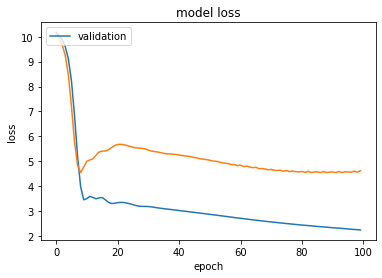

In [17]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.legend(['validation'], loc='upper left')
plt.show()

#Another 100 epochs

In [18]:
history = model.fit([X1,X2,X3], y, epochs=100, verbose=1, batch_size=32, validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True) #callbacks=[checkpoint]


Train on 22 samples, validate on 3 samples
Epoch 1/100
22/22 [==============================] - 1s 23ms/step - loss: 2.2303 - val_loss: 4.5724
Epoch 2/100
22/22 [==============================] - 0s 23ms/step - loss: 2.2182 - val_loss: 4.5970
Epoch 3/100
22/22 [==============================] - 0s 22ms/step - loss: 2.2067 - val_loss: 4.6193
Epoch 4/100
22/22 [==============================] - 0s 20ms/step - loss: 2.1971 - val_loss: 4.5896
Epoch 5/100
22/22 [==============================] - 0s 22ms/step - loss: 2.1885 - val_loss: 4.6611
Epoch 6/100
22/22 [==============================] - 0s 20ms/step - loss: 2.1803 - val_loss: 4.5947
Epoch 7/100
22/22 [==============================] - 0s 22ms/step - loss: 2.1694 - val_loss: 4.6526
Epoch 8/100
22/22 [==============================] - 0s 22ms/step - loss: 2.1569 - val_loss: 4.6381
Epoch 9/100
22/22 [==============================] - 0s 21ms/step - loss: 2.1445 - val_loss: 4.6290
Epoch 10/100
22/22 [==============================] - 0s 

In [21]:
print(y[10])
x1 = X1[10]
x2 = X2[10]
x3 = X3[10]
tmp=''
for w in y[10]:
  if w in ixtoword:
    if w == 'endseq': continue
    tmp += ' ' + ixtoword[w]
print(tmp)

[ 31. 221. 222.   7.  31. 223. 224.   9.   2.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  31. 225.  72. 226. 227.   9.   2.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  62. 228.
   7. 229.   9.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  62. 230.  16.  62. 231. 232.   5.  31. 233. 234.
 137.   2.   0.   0.   0.   0.   0.   0.   0.   0. 100.  80.  68.  93.
  62. 152.   9.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
 the fish pond was the main attraction . endseq the flowers were also pretty . endseq this bug was interesting . endseq this women made this kid go to the plant garden , endseq time for fun on this ride . endseq


In [22]:
yhat = model.predict([x1[np.newaxis,...],x2[np.newaxis,...],x3[np.newaxis,...]], verbose=0)
yhat_s = yhat[0,:,:]
print(yhat_s.shape)
print(np.argmax(yhat_s, axis=-1))
tmp=''
for w in np.argmax(yhat_s, axis=-1):
  if w in ixtoword:
    if w == 'endseq': continue
    tmp += ' ' + ixtoword[w]
print(tmp)

(100, 26572)
[ 31 278   7   7  31 223 224   9   0   0   0   0   0   0   0   0   0   0
   0   0  31 225  72 226 227   9   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  23 228   7 229   9   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  10 103  16  78 231 232  30  31 233   9   9   0
   0   0   0   0   0   0   0   0  31  20  20  49  31  68   9   0   0   0
   0   0   0   0   0   0   0   0   0   0]
 the two was was the main attraction . the flowers were also pretty . then bug was interesting . i temple made us kid go in the plant . . the a a with the fun .


#TRY validation:
Not real validation as I'm using the actual the training set (but just want to confirm that it produces same thing)
However, apparently, it is suffering if it produces one wrong word (result before this are conditioned on the right words, that is why it is producing something similar)

In [27]:
import numpy as np
from scipy.ndimage.interpolation import shift
#X1: 1x5x2048 --images
#X2: 1x5x20  --captions
#X3: 1x5x20    --prev
index_v = 10
x1_v = X1[index_v]
x2_v = np.zeros_like(X2[index_v])
x3_v = np.zeros_like(X3[index_v])
for i in range(5):
  x2_v[i][0] = wordtoix['startseq']
  for j in range(MAX_SEQUENCE_LENGTH-1):
    yhat = model.predict([x1_v[np.newaxis,...],x2_v[np.newaxis,...],x3_v[np.newaxis,...]], verbose=0)
    yhat_s = yhat[0,:,:]
    x2_v[i][j+1] = np.argmax(yhat_s, axis=-1)[j]
  x3_v[i] = x2_v[i]
  x3_v[i] = shift(x3_v[i], 1, cval=0)

print(x3_v)
print(x2_v)
x2_v = np.concatenate(x2_v).ravel()
x3_v = np.concatenate(x3_v).ravel()

caps=''
for w in x2_v:
  if w in ixtoword:
    if ixtoword[w] == 'startseq' or ixtoword[w] =='endseq': continue
    caps += " " + ixtoword[w]
print("Captions:")
print(caps)
      
s=''
for w in x3_v:
  if w in ixtoword:
    #if ixtoword[w] == 'startseq' or ixtoword[w] =='endseq': continue
    s += " "+ ixtoword[w]
print("Sentences:")
print(s)


print("Original") #X3[1]
or_f = np.concatenate(X2[index_v]).ravel()
o=''
for w in or_f:
  if w in ixtoword:
    if ixtoword[w] == 'startseq' or ixtoword[w] =='endseq': continue
    o += " "+ ixtoword[w]

print(o)

[[  0   1  31 278 221 222   7   8   9   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   1  60 225  72 331   9   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   1  60 225  72 331   9   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   1  60 225  72 331   9   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   1  60 225  72 331   9   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
[[  1.  31. 278. 221. 222.   7.   8.   9.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  1.  60. 225.  72. 331.   9.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  1.  60. 225.  72. 331.   9.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  1.  60. 225.  72. 331.   9.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  1.  60. 225.  72. 331.   9.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]]
Captions:
 the two fish pond was amazing . we fl